In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.dates as mdts
import matplotlib.pyplot as plt
import mpl_toolkits as mpltk
from geopy.distance import vincenty
import cartopy.crs as ccrs

In [4]:
# incidents data reading
incdnt_file_name = '../data/PeMS/Incidents/all_text_chp_incident_day_2017_10_11.txt'
inc_header = ['IncidentID', 'CC_Code', 'Incident_No', 'Timestamp', 'Description', 'Location', 'Area', 'Zoom_Map', 'TBxy', 'Latitude', 'Longitude', 'District', 'CountryFIPS_ID', 'CityFIPS_ID', 'Freeway', 'Freeway_direction', 'State_postmile', 'Absolute_postmile', 'Severity', 'Duration', 'Incident_ID', 'Detail_ID', 'Timestamp', 'description']
data_inc = pd.read_csv(incdnt_file_name, sep=',', names=inc_header, parse_dates=[3])
data_inc = (data_inc.dropna(subset=['District']))[data_inc.columns[:-4]]
data_inc = data_inc.astype(dtype={'District':int})
# result: incidents in district under analysis
data_inc_d07 = data_inc[data_inc['District']==7].copy().reset_index()

In [5]:
def filter_by_param(data, param_name, param_val):
    return data[data[param_name] == param_val].copy()


In [6]:
# traffic flow data reading
header = ['Timestamp', 'Station','District', 'Freeway', 'Direction of Travel', 'Lane Type', 'Station Length',
          'Samples', '% Observed', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 
          'Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ', 'Lane 1 Avg Speed', 'Lane 1 Observed',
          'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed',
          'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed',
          'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed',
          'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed',
          'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed',
          'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed',
          'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed']

srs_file_name = '../data/PeMS/Series/d07_text_station_5min_2017_10_11.txt'
data_srs = pd.read_csv(srs_file_name, sep=',', names=header, parse_dates=[0])
data_wo_lanes = data_srs[data_srs.columns[:-40]].copy()

In [ ]:
file_stations = '../data/PeMS/Stations/d07_text_meta_2017_09_20.txt'
header = ['ID', 'Freeway', 'Freeway dir', 'Country', 'City', 'State Postmile', 'Abs Postmile', 
          'Latitude', 'Longitude', 'Length', 'Type', 'Lanes', 'Name',
          'User ID1', 'User ID2', 'User ID3', 'User ID4']
stations_d07 = pd.read_csv(file_stations, sep='\t')
stations_d07 = stations_d07.astype({'Latitude':float, 'Longitude':float})
stations_d07_nona = stations_d07.dropna(subset=['Latitude', 'Longitude']).copy().reset_index(drop=True)
# result: non-empty speed data series  only, stations which provide these data
data_srs_no_null = data_srs.dropna(subset=['Lane 1 Avg Speed'])
stations_active = stations_d07_nona[stations_d07_nona['ID'].isin(data_srs_no_null['Station'].unique())].copy().reset_index(drop=True)

In [8]:
def drop_nulls_column(data, c_name):
    return data.dropna(subset=[c_name])

In [9]:
def plot_flow_w_incidents(flow_data, incdnt_data, frw_no, station_no, chrstc_to_plot = 'Lane 1 Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=2017, month=10, day=11, hour=8)
    datemax = dt.datetime(year=2017, month=10, day=11, hour=20)
    data_srs_no_null = flow_data.dropna(subset=[chrstc_to_plot])
    data_incdnts_by_frw = incdnt_data[incdnt_data['Freeway']==frw_no]
    dates = data_srs_no_null[(data_srs_no_null['Freeway'] == frw_no) & (data_srs_no_null['Station'] == station_no)]['Timestamp']
    speed = data_srs_no_null[(data_srs_no_null['Freeway'] == frw_no) & (data_srs_no_null['Station'] == station_no)][chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for x in data_incdnts_by_frw['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

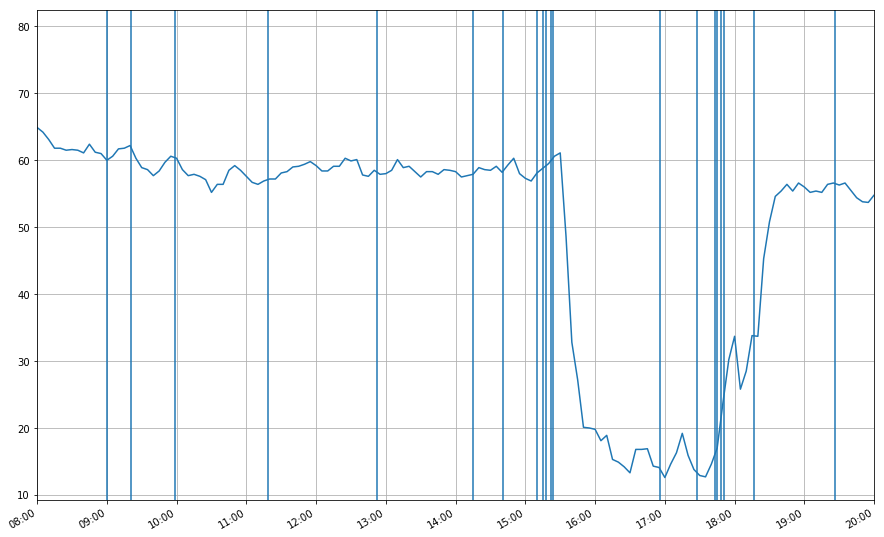

In [10]:
plot_flow_w_incidents(data_srs, data_d07, 101, 716328)

In [11]:
def show_unique_freeways(data):
#     result = np.empty([0,len(data.columns)])
    maximum=0
    for st in data['Station'].unique():
#         result = np.append(result, data[data['Station'] == st])
        crnt_len = len(data[data['Station'] == st]['Freeway'].unique())
        if crnt_len > maximum:
            maximum = crnt_len
    return maximum

In [12]:
print(show_unique_freeways(data_wo_lanes))

1


In [13]:
stations_d07.head()

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4
0,715898,5,S,7,37,40032.0,.71,117.280,33.880183,-118.021787,0.43,ML,3,PHOEBE,2029,NaN,NaN,NaN
1,715900,5,S,7,37,40032.0,1.06,117.630,33.882892,-118.026822,NaN,OR,1,VALLEY VIEW,3255,NaN,NaN,NaN
2,715901,5,N,7,37,40032.0,1.11,117.743,33.883400,-118.027451,NaN,OR,1,VALLEY VIEW,3268,NaN,NaN,NaN
3,715903,5,N,7,37,69154.0,1.56,118.193,33.886992,-118.034125,NaN,OR,1,ALONDRA,3269,NaN,NaN,NaN
4,715906,5,S,7,37,52526.0,3.28,119.850,33.900669,-118.059422,NaN,OR,1,ROSECRANS,3252,NaN,NaN,NaN


In [14]:
min_lon = stations_d07['Longitude'].min()
max_lon = stations_d07['Longitude'].max()
min_lat = stations_d07['Latitude'].min()
max_lat = stations_d07['Latitude'].max()

In [15]:
st1_coords = (stations_d07['Latitude'][0], stations_d07['Longitude'][0])
st2_coords = (stations_d07['Latitude'][1], stations_d07['Longitude'][1])
st1_coords_ccrs = [stations_d07['Latitude'][0], stations_d07['Longitude'][0]]

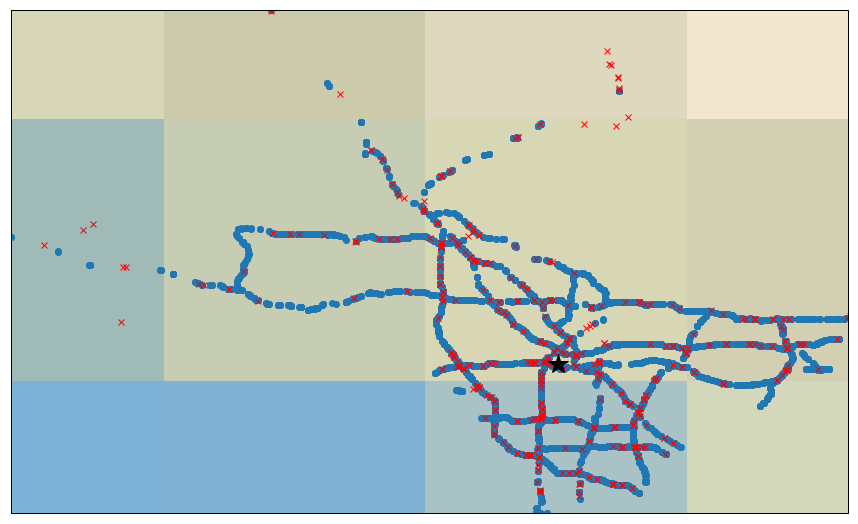

In [16]:
fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection=ccrs.PlateCarree())
ax.stock_img()
plt.plot(stations_d07_nona['Longitude'], stations_d07_nona['Latitude'], transform=ccrs.PlateCarree(), marker='o', linestyle='')
plt.plot(data_inc[data_inc['District']==7]['Longitude'], data_inc[data_inc['District']==7]['Latitude'], marker='x', color='red', linestyle='')
plt.plot(data_inc[data_inc['District']==7]['Longitude'].mean(), data_inc[data_inc['District']==7]['Latitude'].mean()-.05, marker='*', markersize=20, color='black', linestyle='')
# ax.set_xlim()
# ax.set_extent((min_lon-10, max_lon+10, min_lat-10, max_lat+10))
ax.set_extent((min_lon, max_lon, min_lat, max_lat))
plt.show()

In [17]:
most_accidentious_spot = [data_inc[data_inc['District']==7]['Latitude'].mean(), data_inc[data_inc['District']==7]['Longitude'].mean()-.05]
min_dist = 100 
limit_i=100000
for i in range(stations_d07_nona.shape[0]):
    st_coords = [stations_d07_nona['Latitude'][i], stations_d07_nona['Longitude'][i]]
#     print(st_coords)
    crnt_dist = vincenty(most_accidentious_spot, st_coords).kilometers
    if crnt_dist < min_dist:
        min_dist = crnt_dist
        index=i
    if i>limit_i:
        break
print('From hot spot to the closest station {0:.3f} km'.format(min_dist))
print('Station closest to hot spot {} (ID={})'.format(index, stations_d07_nona.loc[index]['ID']))

From hot spot to the closest station 0.095 km
Station closest to hot spot 1274 (ID=717459)


In [220]:
stations_d07_nona[stations_d07_nona.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), most_accidentious_spot).kilometers < 1, axis=1)].shape

(15, 19)

In [19]:
def plot_station_data_w_nearest_incds(flow_data, incdnt_data, stations_data, station_no, vicinity_km, chrstc_to_plot = 'Lane 1 Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=2017, month=10, day=11, hour=7)
    datemax = dt.datetime(year=2017, month=10, day=11, hour=22)
    # filter only data for one station and w/o nans
    data_srs_no_null = flow_data[flow_data['Station'] == station_no]
    data_srs_no_null = data_srs_no_null.dropna(subset=[chrstc_to_plot])
    # station of interest coords
    station_coords = np.asarray(stations_data[stations_data['ID'] == station_no][['Latitude', 'Longitude']])
    # incidents closest to the station
    data_incdnts_nearest = incdnt_data[incdnt_data.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < vicinity_km, axis=1)]
    # x-values
    dates = data_srs_no_null['Timestamp']
    # y-values
    speed = data_srs_no_null[chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for x in data_incdnts_nearest['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

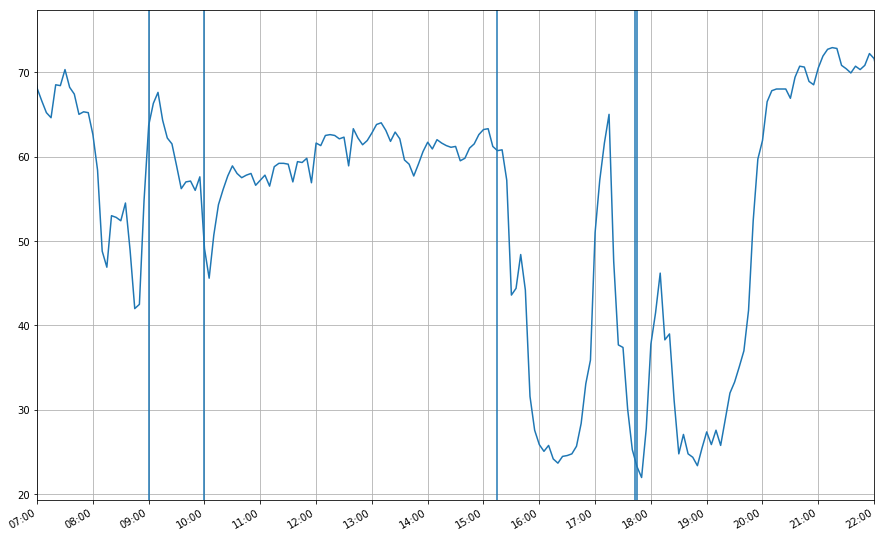

In [25]:
plot_station_data_w_nearest_incds(data_srs, data_inc, stations_active, 717459, vicinity_km=3)

##  Analysis of incidents impact

In [26]:
def isImpacted(srs, ts, ticks_to_count=3):
    srs_b4 = srs[srs['Timestamp'] < ts].sort_values(by='Timestamp', ascending=True).iloc[-ticks_to_count:]
    srs_after = srs[srs['Timestamp'] > ts].sort_values(by='Timestamp', ascending=True).iloc[:ticks_to_count]
    if(srs_b4['Lane 1 Avg Speed'].mean() > srs_after['Lane 1 Avg Speed'].mean()):
        return True
    return False
isImpacted_vec = np.vectorize(isImpacted, excluded=[1,2])

In [28]:
def return_station_series(srs, station):
    return srs[srs['Station']==station]
return_station_series_vec = np.vectorize(return_station_series, excluded=[0])

In [29]:
def get_stations_within_inc_vicinity(incident, stations, vicinity):
    inc_loc = np.asarray(incident[['Latitude', 'Longitude']])
    return stations[stations.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), inc_loc).kilometers < vicinity, axis=1)]

In [104]:
get_stations_within_inc_vicinity(test_inc, stations_active, 1).shape

(16, 18)

In [34]:
loc_test_inc = np.asarray(test_inc[['Latitude', 'Longitude']])

In [452]:
ts_test_inc = test_inc['Timestamp']

In [479]:
data_srs[data_srs['Station'] == nearest_sts.iloc[0]['ID']]['Timestamp'].iloc[0]

Timestamp('2017-10-11 00:00:00')

In [497]:
srs_hotspot = data_srs[data_srs['Station']==717459]

In [591]:
data_srs_no_null.shape

(288, 52)

In [644]:
return_station_series_vec(data_srs_no_null, stations_active['ID'].iloc[:10])[6].shape

(288, 52)

In [148]:
count = 0
for inc in data_inc_d07:
    count += 1
print (count)

21


In [159]:
data_inc_d07.head().apply(lambda x, y: x['Latitude']+y, axis=1, args=(2,))

0    36.006906
1    36.010499
2    36.466522
3    36.033617
4    36.051069
dtype: float64

In [161]:
crnt_vcnt_st = data_inc_d07.head().apply(get_stations_within_inc_vicinity, args=([stations_active,3]), axis=1)

ValueError: cannot copy sequence with size 18 to array axis with dimension 36

In [141]:
def calculate_affect_degree(incidents, series, stations):
    impact = np.array([])
    for crnt_inc in incidents:
        crnt_vcnt_st = get_stations_within_inc_vicinity(crnt_inc, stations, 3)
        series_in_quest = return_station_series_vec(series, crnt_vcnt_st['ID'])
#         print(series_in_quest.shape)
        impacted_result = isImpacted_vec(series_in_quest, crnt_inc['Timestamp'], 3)
        prcnt = impacted_result.sum()/impacted_result.shape[0]
        impact = np.append(impact,prcnt)
    return impact

In [142]:
calculate_affect_degree(data_inc_d07, data_srs_no_null, stations_active).shape

TypeError: string indices must be integers

In [111]:
series_in_quest[0].shape

(288, 52)

In [587]:
np.array([])

array([], dtype=float64)

Hot spot station analysis

In [557]:
station_coords = np.asarray(stations_d07_nona[stations_d07_nona['ID'] == 717459][['Latitude', 'Longitude']])

In [558]:
nearest_accidents = data_d07[data_d07.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < 5, axis=1)]

In [559]:
nearest_accidents['Timestamp']

39    2017-10-11 06:31:00
40    2017-10-11 06:30:00
58    2017-10-11 07:13:00
134   2017-10-11 09:00:00
150   2017-10-11 09:59:00
187   2017-10-11 11:40:00
224   2017-10-11 13:32:00
225   2017-10-11 13:31:00
273   2017-10-11 15:15:00
345   2017-10-11 17:43:00
353   2017-10-11 17:45:00
422   2017-10-11 20:58:00
424   2017-10-11 20:59:00
Name: Timestamp, dtype: datetime64[ns]